In [1]:
from pyiron_contrib.workflow.function import Function

# Pyiron workflows: Introduction and Syntax

Here we will highlight:
- How to instantiate a node
- How to make reusable node classes
- How to connect node inputs and outputs together
- Defining new nodes from special node classes (Fast and SingleValue)
- The five ways of adding nodes to a workflow
- Flow control (i.e. signal channels vs data channels)
- Using pre-defined nodes 

## Instantiating a node

Simple nodes can be defined on-the-fly by passing any callable to the `Function(Node)` class, along with a string (tuple of strings) giving names for the output value(s).

In [2]:
def plus_minus_one(x):
    return x+1, x-1

pm_node = Function(plus_minus_one, "p1", "m1")

This has automatically created a node with input and output data channels whose labels are gathered by inspecting the function:

In [3]:
print(pm_node.inputs.labels, pm_node.outputs.labels)

['x'] ['p1', 'm1']


The output is still empty because we haven't `run` the node.
If we try that now though, we'll just get a type error because the input is not set!
Let's set the input and run the node:

In [4]:
print(pm_node.outputs.to_value_dict())
pm_node.inputs.x = 5
pm_node.run()
print(pm_node.outputs.to_value_dict())

{'p1': None, 'm1': None}
{'p1': 6, 'm1': 4}


Nodes also have the option to `run_on_updates` -- i.e. to attempt a `run` command whenever _any_ of their input data gets updated -- and to `update_on_instantiation`.

In [5]:
def adder(x: int, y: int = 1) -> int:
    return x + y

adder_node = Function(adder, "sum", run_on_updates=True, update_on_instantiation=True)
adder_node.inputs.x = 1
adder_node.outputs.sum.value  # We use `value` to see the data the channel holds

2

We see that now the output got populated automatically when we updated `x`. 
We can safely update it back to something silly without causing an error because of our type hints.

In [6]:
adder_node.inputs.x = "not an integer"
adder_node.inputs.x.type_hint
# No error because the update doesn't trigger a run

int

Note that assigning data to channels with `=` is actually just syntactic sugar for calling the `update` method of the underlying channel:

In [7]:
adder_node.inputs.x.update(2)
adder_node.outputs.sum.value

3

## Reusable node classes

If we're going to use a node many times, we may want to define a new sub-class of `Function` to handle this.

The can be done directly by inheriting from `Function` and overriding it's `__init__` function so that the core functionality of the node (i.e. the node function and output labels) are set in stone, but even easier is to use the `function_node` decorator to do this for you!

The decorator takes the output labels and whatever other class kwargs you want to override, and the function is defined like any other node function:

In [8]:
from pyiron_contrib.workflow.function import function_node

In [9]:
@function_node("diff", run_on_updates=True, update_on_instantiation=True)
def subtract_node(x: int | float = 2, y: int | float = 1) -> int | float:
    return x - y

sn = subtract_node()
print("class name =", sn.__class__.__name__)
print("label =", sn.label)
print("default output =", sn.outputs.diff.value)

class name = SubtractNode
label = subtract_node
default output = 1


Earlier we saw that we could set input data by function defaults, or by directly setting the `.inputs.*` channel values with an `=` assignement or `.update` method call.

We can also set the input of a node instance at instantiation by passing the input labels as kwargs!

In [10]:
subtract_node(x=10, y=20).outputs.diff.value

-10

## Node connections 

Next, we want to make connections between nodes. Instead of `update` we can use the `connect` method to accomplish this, or we can do it with the other syntactic sugar we saw for regular data (i.e. direct attribute access or using kwargs at instantiation):

In [11]:
@function_node("sum", run_on_updates=True, update_on_instantiation=True)
def add_node(x: int | float = 1, y: int | float = 1) -> int | float:
    return x + y

add1 = add_node()
add2 = add_node(x=2, y=2)
sub = subtract_node(x=add1.outputs.sum, y=add2.outputs.sum)
print(
    f"{add1.outputs.sum.value} - {add2.outputs.sum.value} = {sub.outputs.diff.value}"
)

2 - 4 = -2


Because we've set all of our nodes to run automatically on updates, we can change upstream data and see the result propogate downstream immediately:

In [12]:
add1.inputs.x = 10
print(
    f"{add1.outputs.sum.value} - {add2.outputs.sum.value} = {sub.outputs.diff.value}"
)

11 - 4 = 7


## Special nodes

In addition to the basic `Function` class, for the sake of convenience we also offer `Fast(Function)` -- which enforces that all the node function inputs are type-hinted and have defaults, then sets `run_on_updates=True` and `update_on_instantiation=True` --, and `SingleValue(Fast)` -- which further enforces that there is only a _single_ return value to the node function (i.e. a single output label), and then lets attribute and item access fall back to looking for attributes and items of this single output value. Of course there are decorators available for both of these.

Let's look at a use case:

In [13]:
import numpy as np
from pyiron_contrib.workflow.function import single_value_node

In [14]:
@single_value_node("linspace")
def linspace_node(
    start: int | float = 0, stop: int | float = 1, num: int = 50
):
    return np.linspace(start=start, stop=stop, num=num)

lin = linspace_node()

print(type(lin.outputs.linspace.value))  # Output is just what we expect
print(lin[1:4])  # Gets items from the output
print(lin.mean())  # Finds the method on the output

<class 'numpy.ndarray'>
[0.02040816 0.04081633 0.06122449]
0.5


# Workflows

Typically, you will have a group of nodes working together with their connections.
We call these groups workflows, and offer a `Workflow(Node)` object as a single point of entry -- i.e. most of the time you shouldn't need the node imports used above, because the decorators are available right on the workflow class.

In [15]:
from pyiron_contrib.workflow.workflow import Workflow

@Workflow.wrap_as.single_value_node("is_greater")
def greater_than_half(x: int | float | bool = 0) -> bool:
    """The functionality doesn't matter here, it's just an example"""
    return x > 0.5

## Adding nodes to a workflow

All five of the following approaches are equivalent ways to add a node to a workflow:

In [16]:
n1 = greater_than_half(label="n1")

wf = Workflow("my_wf", n1)  # As args at init
wf.add.Function(lambda: x + 1, "p1", label="n2")  # Instantiating from the node adder
wf.add(greater_than_half(label="n3"))  # Instantiating then passing to node adder
wf.n4 = greater_than_half(label="will_get_overwritten_with_n4")  # Set attribute to instance
greater_than_half(label="n5", parent=wf)  # By passing the workflow to the node

for k, v in wf.nodes.items():
    print(k, v.label, v)

n1 n1 n1 (GreaterThanHalf) output single-value: False
n2 n2 <pyiron_contrib.workflow.function.Function object at 0x150637550>
n3 n3 n3 (GreaterThanHalf) output single-value: False
n4 n4 n4 (GreaterThanHalf) output single-value: False
n5 n5 n5 (GreaterThanHalf) output single-value: False


# Flow control

By default, when a node runs and updates its output, this triggers outputs in all downstream connections. This is useful when all your node functions are small and light, but there may come times when you want something other than this simple "push" flow.

In addition to input and output data channels, nodes also have "signal" channels available. Input signals are bound to a callback function (typically one of its node's methods), and output signals trigger the callbacks for all the input signal channels they're connected to.

Standard nodes have a `run` input signal (which is, unsurprisingly, bound to the `run` method), and a `ran` output signal (which, again, hopefully with no great surprise, is triggered at the end of the `run` method.)

Below is a super simple example of how these signal channels can be used to delay execution and manually control flow:

In [17]:
@function_node("y")
def linear(x):
    return x

@function_node("z")
def times_two(y):
    return 2 * y

l = linear(x=1)
l.run()
t2 = times_two(y=l.outputs.y)
print(t2.inputs.y, t2.outputs.z)

1 None


Now the input of `t2` got updated when the connection is made, but by default we told this node not to do any automatic updates, so the output has its uninitialized value of `None`.

Often, you will probably want to have nodes with data connections to have signal connections, but this is not strictly required. Here, we'll introduce a (not strictly necessary) third node to control starting the workflow, and chain together to signals from our two functional nodes.

Note that we have all the same syntacic sugar from data channels when creating connections between signal channels.

In [18]:
@function_node("void")
def control():
    return

c = control()
l.signals.input.run = c.signals.output.ran
t2.signals.input.run = l.signals.output.ran
c.run()
print(t2.outputs.z.value)

2


It is also possible to flag certain inputs channels so they require updates after each time their node is run before they are `ready` again. These can be defined either at the node instantiation, or after the fact using a method on the channel. Both approaches are shown in the example below:

In [19]:
import matplotlib.pyplot as plt

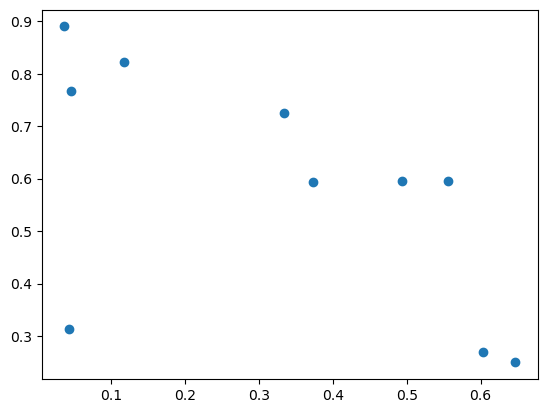

In [20]:
@single_value_node("array")
def noise(length: int = 1):
    return np.random.rand(length)

@function_node("fig")
def plot(x, y):
    return plt.scatter(x, y)

x = noise(length=10)
y = noise(length=10)
f = plot(
    x=x, 
    y=y, 
    run_on_updates=True, 
    update_on_instantiation=True,
    channels_requiring_update_after_run=["x"],
)
f.inputs.y.require_update_after_node_runs(wait_now=True)

Now that the plotting node has run, its input channels are no longer `ready` because they are waiting for a fresh update:

In [21]:
f.inputs.x.ready, f.inputs.y.ready

(False, False)

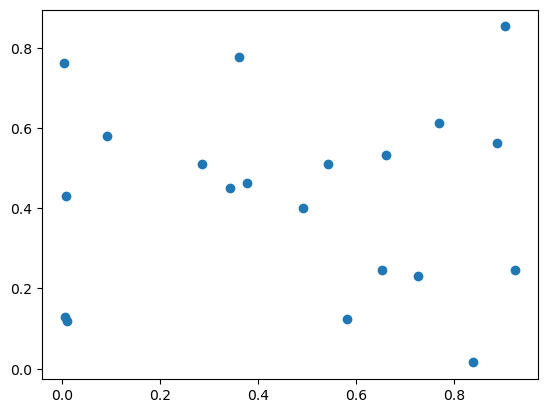

In [22]:
x.inputs.length = 20
y.inputs.length = 20

Note that in the second cell, `f` is trying to update itself as soon as its inputs are ready, so if we _hadn't_ set the `f.inputs.y` channel to wait for an update, we would have gotten an error from the plotting command due to the mis-matched lengths of the x- and y-arrays.

# Example with pre-built nodes

Currently we have a handfull of pre-build nodes available for import from the `nodes` package. Let's use these to quickly put together a workflow for looking at some MD data.

The `calc_md`, node is _not_ at `Fast`, but we happen to know that the calculation we're doing here is very easy, so we'll set `run_on_updates` and `update_at_instantiation` to `True`.

Finally, `SingleValue` has one more piece of syntactic sugar: when you're making a connection to the (single!) output channel, you can just pass the node itself!

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:175: UserWarning: Reassigning the node bulk_structure to the label structure when adding it to the parent with_prebuilt.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:175: UserWarning: Reassigning the node lammps to the label engine when adding it to the parent with_prebuilt.
  warn(


The job JUSTAJOBNAME was saved and received the ID: 9553


/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:175: UserWarning: Reassigning the node calc_md to the label calc when adding it to the parent with_prebuilt.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:175: UserWarning: Reassigning the node scatter to the label plot when adding it to the parent with_prebuilt.
  warn(


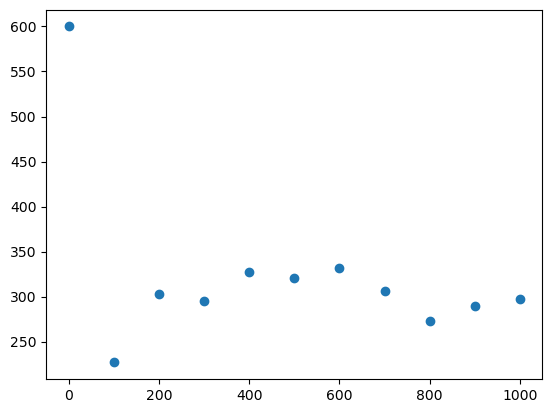

In [23]:
wf = Workflow("with_prebuilt")

wf.structure = wf.add.atomistics.BulkStructure(repeat=3, cubic=True, element="Al")
wf.engine = wf.add.atomistics.Lammps(structure=wf.structure)
wf.calc = wf.add.atomistics.CalcMd(
    job=wf.engine, 
    run_on_updates=True, 
    update_on_instantiation=True
)
wf.plot = wf.add.standard.Scatter(
    x=wf.calc.outputs.steps, 
    y=wf.calc.outputs.temperature
)